In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchsummary
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00


In [5]:
import captum
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [51]:
# these are the mean and std of the data per channel
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

def denormalize(tensor):
    tensor = tensor*std + mean
    return tensor

# function for viewling image
def get_rgb_img(img):
    # arrange channels
    img = img.numpy().transpose((1,2,0))

    # use mean and std values
    img = denormalize(img)

    # clip values and view image
    rgb_img = np.clip(img,0,1)
    #plt.imshow(rgb_img)

    return np.float32(rgb_img)

## Load Test Data

In [31]:
# load test dataset
test_data = datasets.CIFAR10(root='./data', train=False, download=True,
                                              transform=transform)
test_dataloader = DataLoader(test_data, batch_size=32, num_workers=2)

Files already downloaded and verified


In [27]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [17]:
class CustomModel(nn.Module):
    def __init__(self, model_arc_path, model_weights_path, name):
        super(CustomModel, self).__init__()
        self.model = torch.load(model_arc_path)
        self.model.load_state_dict(torch.load(model_weights_path))
        self.name = name

    def forward(self, x):
        return self.model(x)

## Load Model

In [11]:
arc_path = '/content/drive/MyDrive/Colab Notebooks/modified_model/vgg16_arc.pth'
weights_path = '/content/drive/MyDrive/Colab Notebooks/modified_model/vgg16_weights.pth'
name = 'vgg16_cifar10'

In [18]:
vgg16cf_model = CustomModel(arc_path, weights_path, name)
vgg16cf_model

CustomModel(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

## Function for obtaining gradcam attention map

In [147]:
def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)

    normalized_img = (img - min_val) / (max_val - min_val)
    normalized_img *= 255
    return normalized_img.astype(int)

def get_attention_map(model, x, layer, alpha):

    model.to(device)
    model.eval()

    # convert data to tensor dimension
    input_img = x.unsqueeze(0)
    logps = model(input_img)
    output = torch.exp(logps)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()

    # get grad cam results
    layer_gradcam = LayerGradCam(model, model.model.features[layer])
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

    # overlay heatmap over rgb image
    rgb_image = normalize_image(get_rgb_img(x))
    heatmap_image = normalize_image(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy())

    # Resize heatmap if sizes are different
    if rgb_image.shape[:2] != heatmap_image.shape[:2]:
        heatmap_image = cv2.resize(heatmap_image, (rgb_image.shape[1], rgb_image.shape[0]))

    # Apply colormap to heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(heatmap_image), cv2.COLORMAP_JET)

    overlaid_image = normalize_image((1-alpha)*rgb_image + alpha*heatmap_colored)

    return overlaid_image

## Iterate through dataloader

In [32]:
images, labels = next(iter(test_dataloader))

array([[[0.92156863, 0.92156863, 0.92156863],
        [0.92156863, 0.92156863, 0.92156863],
        [0.92156863, 0.92156863, 0.92156863],
        ...,
        [0.9098039 , 0.9098039 , 0.909804  ],
        [0.9098039 , 0.9098039 , 0.909804  ],
        [0.9098039 , 0.9098039 , 0.909804  ]],

       [[0.92156863, 0.92156863, 0.92156863],
        [0.92156863, 0.92156863, 0.92156863],
        [0.92156863, 0.92156863, 0.92156863],
        ...,
        [0.9098039 , 0.9098039 , 0.909804  ],
        [0.9098039 , 0.9098039 , 0.909804  ],
        [0.9098039 , 0.9098039 , 0.909804  ]],

       [[0.92156863, 0.92156863, 0.92156863],
        [0.92156863, 0.92156863, 0.92156863],
        [0.92156863, 0.92156863, 0.92156863],
        ...,
        [0.9098039 , 0.9098039 , 0.909804  ],
        [0.9098039 , 0.9098039 , 0.909804  ],
        [0.9098039 , 0.9098039 , 0.909804  ]],

       ...,

       [[0.33333334, 0.39607844, 0.3254902 ],
        [0.33333334, 0.39607844, 0.3254902 ],
        [0.33333334, 0

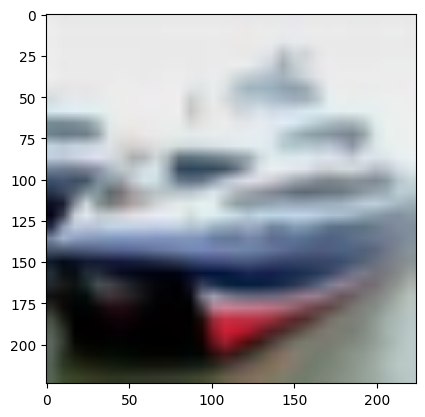

In [33]:
get_rgb_img(images[1])

In [34]:
CIFAR10_classes[labels[1].item()]

'ship'

In [64]:
x = images[5]
layer = 28

In [148]:
overlaid_img = get_attention_map(vgg16cf_model, x, layer, 0.3)

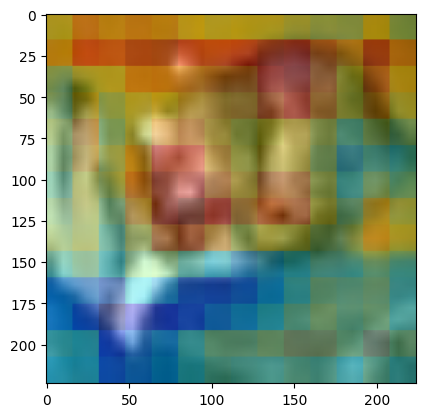

In [149]:
plt.imshow(overlaid_img)